# DOE 本番解析用 (base) v5

### ライブラリの一括インポート

In [32]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [33]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [34]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [35]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## CSV ファイル一覧の取得

In [36]:
name_doe = "doe-11"  # 実験計画名（フォルダ名）

name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

## CSV ファイルの読み込み、連結

In [37]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

col_x = "THRESHOLD_PM_MIN"
col_y = "THRESHOLD_DDR_MIN"
list_col = [col_x, col_y, "trade", "total"]
list_col_new = [col_x, col_y, "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件 [{name_doe}]")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                   file  code  trade   total  THRESHOLD_PM_MIN  \
0   ticks_20250819.xlsx  7011      6   600.0               2.5   
1   ticks_20250819.xlsx  7011      6  1200.0               5.0   
2   ticks_20250819.xlsx  7011      6   400.0              10.0   
3   ticks_20250819.xlsx  7011      6   700.0              12.5   
4   ticks_20250819.xlsx  7011      6  1100.0              15.0   
5   ticks_20250819.xlsx  7011      6  1100.0              17.5   
6   ticks_20250819.xlsx  7011      6   100.0              20.0   
7   ticks_20250819.xlsx  7011      6   600.0               2.5   
8   ticks_20250819.xlsx  7011      6   900.0               5.0   
9   ticks_20250819.xlsx  7011      6   600.0              10.0   
10  ticks_20250819.xlsx  7011      6   600.0              12.5   
11  ticks_20250819.xlsx  7011      6   800.0              15.0   
12  ticks_20250819.xlsx  7011      6   800.0              17.5   
13  ticks_20250819.xlsx  7011      6   100.0           

### 本日の条件

In [38]:
x_por = 17.5
y_por = 0.4
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN  取引回数      損益 備考
26              17.5                0.4    34  2400.0   


## 最終日のデータだけで作成した等高線図

In [39]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

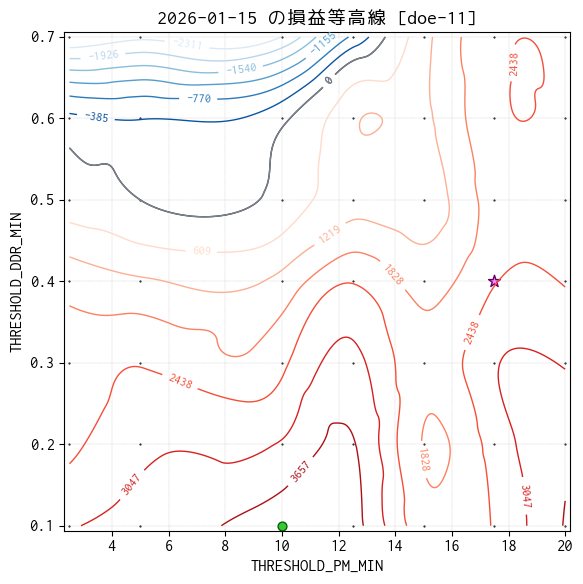

In [40]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

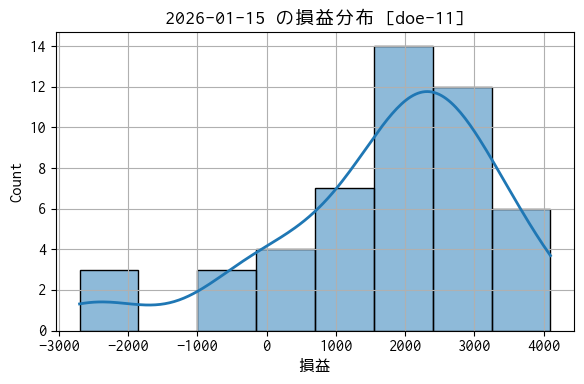

In [41]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [{name_doe}]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [42]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                     file  code  trade    total  THRESHOLD_PM_MIN  \
2573  ticks_20251105.xlsx  7011     36  27200.0              15.0   

      THRESHOLD_DDR_MIN  
2573                0.4  

最低損益
                     file  code  trade    total  THRESHOLD_PM_MIN  \
2470  ticks_20251031.xlsx  7011     50 -11300.0              20.0   

      THRESHOLD_DDR_MIN  
2470                0.3  


## サマリ統計の算出

In [43]:
factor_cols = [col_x, col_y]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values([col_y, col_x], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = (
    df_summary.style.format({"trade": "{:.0f}", "total": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)

html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_summary.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN      trade        total
0                2.5                0.1  16.383838   162.626263
1                5.0                0.1  16.343434   200.000000
2               10.0                0.1  16.343434   455.555556
3               12.5                0.1  16.323232   620.202020
4               15.0                0.1  16.303030  1097.979798
5               17.5                0.1  16.282828  1050.505051
6               20.0                0.1  16.262626  1125.252525
7                2.5                0.2  16.383838   203.030303
8                5.0                0.2  16.343434   272.727273
9               10.0                0.2  16.343434   518.181818
10              12.5                0.2  16.323232   721.212121
11              15.0                0.2  16.303030   993.939394
12              17.5                0.2  16.282828  1126.262626
13              20.0                0.2  16.262626  1070.707071
14               2.5              

## 日付 × 条件 で損益を集計

In [44]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
                0       1       2       3       4       5       6       7   \
2025-08-19   600.0  1200.0   400.0   700.0  1100.0  1100.0   100.0   600.0   
2025-08-20  1500.0  1800.0  2200.0  2700.0  3500.0  4300.0  4600.0  1500.0   
2025-08-21  -300.0 -1200.0  -800.0  -100.0  -100.0  -100.0   200.0  -300.0   
2025-08-22   700.0  1700.0  2200.0  2700.0  4000.0  4500.0  4500.0  1200.0   
2025-08-25 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0 -1000.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-08 -2800.0 -1400.0 -1900.0 -1400.0  -400.0  -400.0 -1400.0 -2900.0   
2026-01-09   700.0  1300.0  -400.0  -100.0  -100.0   400.0  1300.0   600.0   
2026-01-13  -600.0 -1100.0  -100.0   700.0  2100.0  3100.0  3700.0  -700.0   
2026-01-14  -900.0 -2800.0 -3300.0 -3100.0 -2300.0 -2600.0 -1800.0 -1200.0   
2026-01-15  3000.0  3300.0  4100.0  3900.0  2100.0  2500.0  3700.0  2300.0   

                8       9   ...      39    

## 平均損益の算出

In [45]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均損益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均損益（逆ソート後）")
print(ser_ranking)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2026-01-15, n = 99 days

df_mean: 新しい日付から古い日付と逆順に平均損益を算出
                     0            1            2            3            4   \
2025-08-19   600.000000  1200.000000   400.000000   700.000000  1100.000000   
2025-08-20  1050.000000  1500.000000  1300.000000  1700.000000  2300.000000   
2025-08-21   600.000000   600.000000   600.000000  1100.000000  1500.000000   
2025-08-22   625.000000   875.000000  1000.000000  1500.000000  2125.000000   
2025-08-25   300.000000   500.000000   600.000000  1000.000000  1500.000000   
...                 ...          ...          ...          ...          ...   
2026-01-08   146.315789   201.052632   471.578947   631.578947  1125.263158   
2026-01-09   152.083333   212.500000   462.500000   623.958333  1112.500000   
2026-01-13   144.329897   198.969072   456.701031   624.742268  1122.680412   
2026-01-14   133.673469   168.367347   418.367347   586.734694  1087.755102   
2026-01-15   162.626263   20

### 検算

In [46]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## 今日（最終データ）のベスト損益

In [47]:
dt_last = df_raw.index[-1]
df_raw_last = df_raw.loc[str(dt_last.date())]
total_last_max = df_raw_last.max()
colname_last_best = df_raw_last[df_raw_last == total_last_max].index[0]

list_col = [col_x, col_y, "total"]
df_last_max = pd.DataFrame(df_summary.loc[colname_last_best][list_col]).T.copy()
df_last_max.loc[colname_last_best, "total"] = total_last_max
list_col_new = [col_x, col_y, "損益"]
df_last_max.columns = list_col_new
print(f"最終日 ({dt_last.date()}) の最高損益条件")
print(df_last_max)

最終日 (2026-01-15) の最高損益条件
   THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN      損益
2              10.0                0.1  4100.0


## ランキング

In [48]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = [col_x, col_y, "取引回数", "平均損益"]
df_best.columns = list_col

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "平均損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = [col_x, col_y, "取引回数", "平均損益"]
df_negative.columns = list_col

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN       取引回数         平均損益
26              17.5                0.4  16.262626  1539.393939
27              20.0                0.4  16.242424  1534.343434
47              17.5                0.7  16.141414  1397.979798
34              20.0                0.5  16.181818  1386.868687
46              15.0                0.7  16.161616  1377.777778
---
[Bad Conditions]
Empty DataFrame
Columns: [THRESHOLD_PM_MIN, THRESHOLD_DDR_MIN, 取引回数, 平均損益]
Index: []


## 実験条件毎の損益トレンド

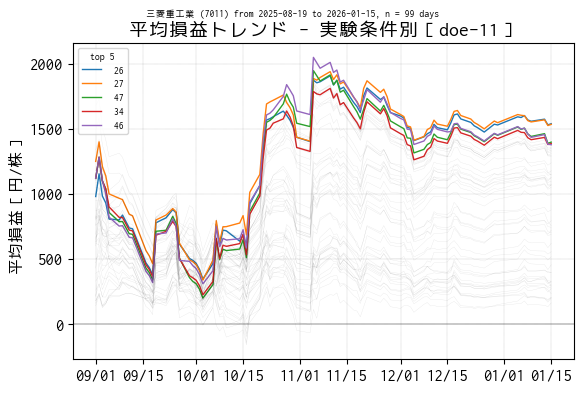

In [49]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均損益［円/株］")
ax.set_title(f"平均損益トレンド - 実験条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ損益条件 (mean) の日別損益トレンド

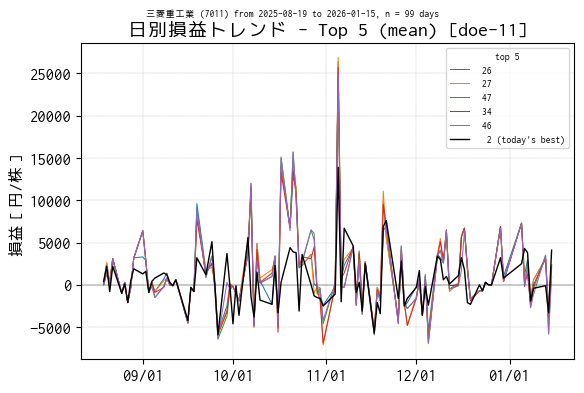

In [50]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"日別損益トレンド - Top 5 (mean) [{name_doe}]")
# 凡例
lg = ax.legend(fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})
output = os.path.join(date_str, f"{name_code}_trend_daily_profit_1.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

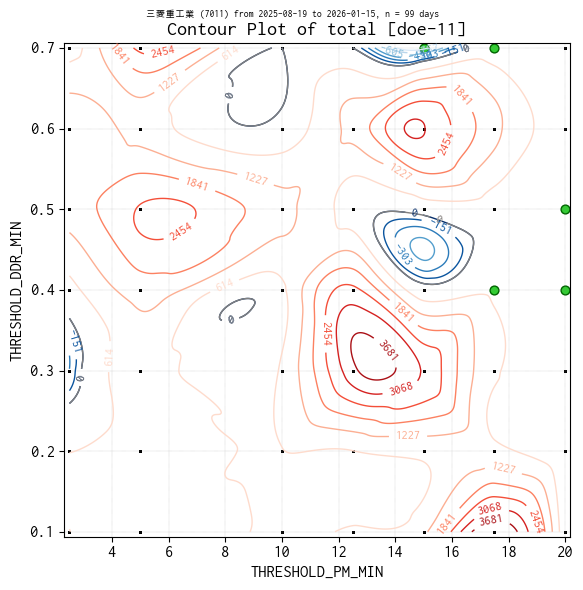

In [51]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
# col_x = "PERIOD_MA_1"
# col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
# cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
# ax.clabel(cont, inline=True, fontsize=9)

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"Contour Plot of total [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()

## メディアン損益の算出

In [52]:
df_median = df_raw.copy()
# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
三菱重工業 (7011) from 2025-08-19 to 2026-01-15, n = 99 days


In [53]:
n = len(df_median.index)

In [54]:
df_median[:n].median()

0     300.0
1     400.0
2     100.0
3     300.0
4     600.0
5     400.0
6     600.0
7     300.0
8     400.0
9     100.0
10    300.0
11    600.0
12    600.0
13    600.0
14    200.0
15    300.0
16    100.0
17    300.0
18    600.0
19    500.0
20    500.0
21    300.0
22    300.0
23    100.0
24    200.0
25    400.0
26    500.0
27    400.0
28    200.0
29      0.0
30    200.0
31    300.0
32    300.0
33    300.0
34    300.0
35    100.0
36      0.0
37    100.0
38    200.0
39    300.0
40    200.0
41    300.0
42    100.0
43    200.0
44      0.0
45    100.0
46    200.0
47    200.0
48    200.0
dtype: float64

In [55]:
# メディアン損益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン損益を算出")
print(df_median)

# 最終日の損益収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン損益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン損益を算出
                0       1       2       3       4       5       6       7   \
2025-08-19   600.0  1200.0   400.0   700.0  1100.0  1100.0   100.0   600.0   
2025-08-20  1050.0  1500.0  1300.0  1700.0  2300.0  2700.0  2350.0  1050.0   
2025-08-21   600.0  1200.0   400.0   700.0  1100.0  1100.0   200.0   600.0   
2025-08-22   650.0  1450.0  1300.0  1700.0  2300.0  2700.0  2350.0   900.0   
2025-08-25   600.0  1200.0   400.0   700.0  1100.0  1100.0   200.0   600.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-08   300.0   400.0   100.0   300.0   600.0   400.0   500.0   300.0   
2026-01-09   300.0   400.0   100.0   200.0   550.0   400.0   550.0   300.0   
2026-01-13   300.0   400.0   100.0   300.0   600.0   400.0   600.0   300.0   
2026-01-14   300.0   300.0    50.0   200.0   550.0   400.0   550.0   250.0   
2026-01-15   300.0   400.0   100.0   300.0   600.0   400.0   600.0   300.0   

                8       9

## サマリ統計（メディアン）

In [56]:
factor_cols = [col_x, col_y]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values([col_y, col_x], ignore_index=True)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN  trade  total
0                2.5                0.1   14.0  300.0
1                5.0                0.1   14.0  400.0
2               10.0                0.1   14.0  100.0
3               12.5                0.1   14.0  300.0
4               15.0                0.1   14.0  600.0
5               17.5                0.1   14.0  400.0
6               20.0                0.1   14.0  600.0
7                2.5                0.2   14.0  300.0
8                5.0                0.2   14.0  400.0
9               10.0                0.2   14.0  100.0
10              12.5                0.2   14.0  300.0
11              15.0                0.2   14.0  600.0
12              17.5                0.2   14.0  600.0
13              20.0                0.2   14.0  600.0
14               2.5                0.3   14.0  200.0
15               5.0                0.3   14.0  300.0
16              10.0                0.3   14.0  100.0
17             

### 検算

In [57]:
"""
サマリ統計 (df_summary) の平均値と、算出したメジアン損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [58]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions].copy()

list_col = [col_x, col_y, "取引回数", "メジアン損益"]
df_best.columns = list_col

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "メジアン損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = [col_x, col_y, "取引回数", "メジアン損益"]
df_negative.columns = list_col

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
    THRESHOLD_PM_MIN  THRESHOLD_DDR_MIN  取引回数  メジアン損益
4               15.0                0.1  14.0   600.0
13              20.0                0.2  14.0   600.0
6               20.0                0.1  14.0   600.0
11              15.0                0.2  14.0   600.0
12              17.5                0.2  14.0   600.0
18              15.0                0.3  14.0   600.0
26              17.5                0.4  14.0   500.0
19              17.5                0.3  14.0   500.0
20              20.0                0.3  14.0   500.0
5               17.5                0.1  14.0   400.0
---
[Bad Conditions]
Empty DataFrame
Columns: [THRESHOLD_PM_MIN, THRESHOLD_DDR_MIN, 取引回数, メジアン損益]
Index: []


## 実験条件毎の収益トレンド（メジアン）

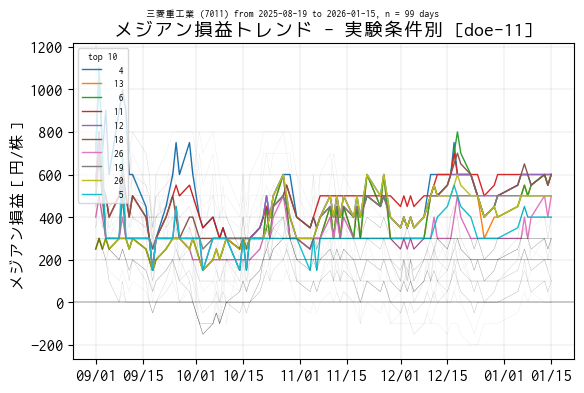

In [59]:
# ---------------------------------------------------------
# 実験条件毎のメジアン損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン損益［円/株］")
ax.set_title(f"メジアン損益トレンド - 実験条件別 [{name_doe}]")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (median) の日別損益トレンド

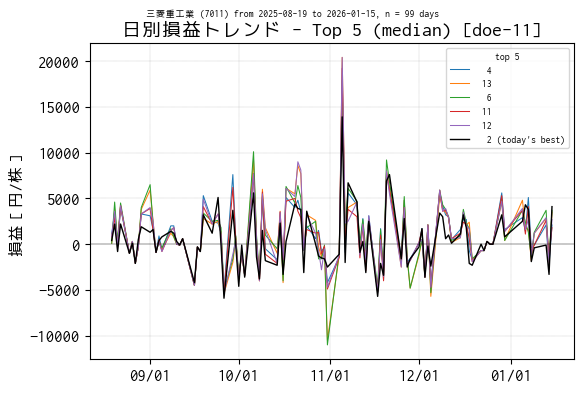

In [60]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"日別損益トレンド - Top 5 (median) [{name_doe}]")
# 凡例
lg = ax.legend(fontsize=7)
lg.set_title("top 5", prop={"size": 7})
output = os.path.join(date_str, f"{name_code}_trend_daily_profit_2.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()